In [3]:
import torch
import matplotlib.pyplot as plt

In [10]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

In [13]:
sam_x = []
sam_y = []
x = torch.tensor(20., requires_grad=True)
base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer = SAM([x], base_optimizer, rho=0.05, lr=0.01)

for i in range(1000):
    sam_x.append(x.item())
    optimizer.zero_grad()
    y = x**2
    y.backward()
    optimizer.first_step(zero_grad=True)
    
    print(f"Iter {i} Step 1: x = {x}, y = {y}")
    
    y = x**2
    y.backward()
    optimizer.second_step(zero_grad=True)
    
    print(f"Iter {i} Step 2: x = {x}, y = {y}")
    
    sam_y.append(y.item())

Iter 0 Step 1: x = 20.049999237060547, y = 400.0
Iter 0 Step 2: x = 19.599000930786133, y = 402.0024719238281
Iter 1 Step 1: x = 19.64900016784668, y = 384.120849609375
Iter 1 Step 2: x = 19.20602035522461, y = 386.0832214355469
Iter 2 Step 1: x = 19.256019592285156, y = 368.8712158203125
Iter 2 Step 2: x = 18.820899963378906, y = 370.7942810058594
Iter 3 Step 1: x = 18.870899200439453, y = 354.2262878417969
Iter 3 Step 2: x = 18.4434814453125, y = 356.11083984375
Iter 4 Step 1: x = 18.493480682373047, y = 340.1620178222656
Iter 4 Step 2: x = 18.073612213134766, y = 342.0088195800781
Iter 5 Step 1: x = 18.123611450195312, y = 326.65545654296875
Iter 5 Step 2: x = 17.711139678955078, y = 328.4653015136719
Iter 6 Step 1: x = 17.761138916015625, y = 313.6844787597656
Iter 6 Step 2: x = 17.35591697692871, y = 315.45806884765625
Iter 7 Step 1: x = 17.405916213989258, y = 301.22784423828125
Iter 7 Step 2: x = 17.00779914855957, y = 302.9659118652344
Iter 8 Step 1: x = 17.057798385620117, y =

In [8]:
sgd_x = []
sgd_y = []
x = torch.tensor(20., requires_grad=True)
optimizer = torch.optim.SGD([x], lr=0.1)

for i in range(100):
    sgd_x.append(x.item())
    optimizer.zero_grad()
    y = x**2
    y.backward()
    optimizer.step()
    
    print(f"Iter {i}: x = {x}, y = {y}")
    
    sgd_y.append(y.item())

Iter 0: x = 16.0, y = 400.0
Iter 1: x = 12.800000190734863, y = 256.0
Iter 2: x = 10.239999771118164, y = 163.8400115966797
Iter 3: x = 8.191999435424805, y = 104.85759735107422
Iter 4: x = 6.5535993576049805, y = 67.10885620117188
Iter 5: x = 5.242879390716553, y = 42.94966506958008
Iter 6: x = 4.194303512573242, y = 27.487783432006836
Iter 7: x = 3.355442762374878, y = 17.592182159423828
Iter 8: x = 2.684354305267334, y = 11.25899600982666
Iter 9: x = 2.1474833488464355, y = 7.205758094787598
Iter 10: x = 1.7179867029190063, y = 4.611684799194336
Iter 11: x = 1.374389410018921, y = 2.9514782428741455
Iter 12: x = 1.0995115041732788, y = 1.888946294784546
Iter 13: x = 0.879609227180481, y = 1.2089256048202515
Iter 14: x = 0.7036873698234558, y = 0.7737123966217041
Iter 15: x = 0.5629498958587646, y = 0.49517592787742615
Iter 16: x = 0.45035991072654724, y = 0.31691259145736694
Iter 17: x = 0.36028793454170227, y = 0.20282405614852905
Iter 18: x = 0.28823035955429077, y = 0.12980739772

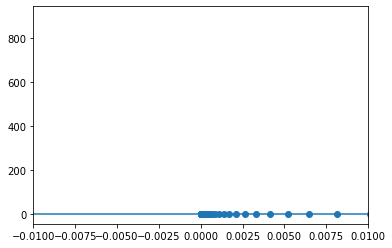

In [42]:
import numpy as np

# create 1000 equally spaced points between -10 and 10
x = np.linspace(-30, 30, 100)

# calculate the y value for each element of the x vector
y = x**2

fig, ax = plt.subplots()
plt.xlim(-0.01, 0.01)
ax.plot(x, y)
ax.scatter(sgd_x, sgd_y)

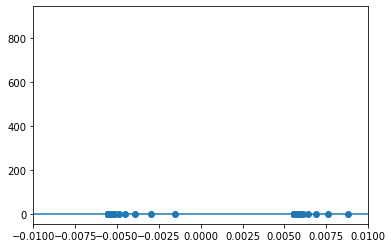

In [43]:
fig, ax = plt.subplots()
plt.xlim(-0.01, 0.01)
ax.plot(x, y)
ax.scatter(sam_x, sam_y)